In [15]:
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

**Se importan los archivos**

In [2]:
store_sales = pd.read_csv('train.csv')
store_sales_test = pd.read_csv('test.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv('holidays_events.csv', dtype={'type': 'category','locale': 'category',
                            'locale_name': 'category','description': 'category','transferred': 'bool',}, parse_dates=['date'], infer_datetime_format=True)
transactions = pd.read_csv('transactions.csv', parse_dates=['date'])
stores = pd.read_csv('stores.csv')
store_sales.head()

id        date  store_nbr      family  sales  onpromotion
0   0  2013-01-01          1  AUTOMOTIVE    0.0            0
1   1  2013-01-01          1   BABY CARE    0.0            0
2   2  2013-01-01          1      BEAUTY    0.0            0
3   3  2013-01-01          1   BEVERAGES    0.0            0
4   4  2013-01-01          1       BOOKS    0.0            0

**Data Exploration**

In [3]:
store_sales.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   date         object 
 2   store_nbr    int64  
 3   family       object 
 4   sales        float64
 5   onpromotion  int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 137.4+ MB


In [4]:
store_sales.isnull().sum()

id             0
date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

***Data Preprocessing***

In [19]:
fecha_corte = list(np.sort(store_sales.date.unique()))[int(np.round(0.99*len(store_sales.date.unique())))]
   
store_sales_train = store_sales.loc[store_sales['date'] <= fecha_corte]
store_sales_val = store_sales.loc[store_sales['date'] > fecha_corte]

In [20]:
store_sales_train['date'] = pd.to_datetime(store_sales_train['date'])
store_sales_train['date'] = store_sales_train.date.dt.to_period('D')
store_sales_val['date'] = pd.to_datetime(store_sales_val['date'])
store_sales_val['date'] = store_sales_val.date.dt.to_period('D')

<ipython-input-20-2f31bda33561>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-2f31bda33561>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-2f31bda33561>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-20-2f31bda

In [21]:
store_sales_train = store_sales_train.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales_val = store_sales_val.set_index(['store_nbr', 'family', 'date']).sort_index()

In [10]:
store_sales_train

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2013-01-01        0    0.0            0
                     2013-01-02     1782    2.0            0
                     2013-01-03     3564    3.0            0
                     2013-01-04     5346    3.0            0
                     2013-01-05     7128    5.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-07-26  2965115    3.0            1
                     2017-07-27  2966897    2.0            0
                     2017-07-28  2968679    4.0            0
                     2017-07-29  2970461    4.0            2
                     2017-07-30  2972243    4.0            0

[2972376 rows x 3 columns]

In [11]:
store_sales_val

id  sales  onpromotion
store_nbr family     date                                   
1         AUTOMOTIVE 2017-07-31  2972376    8.0            0
                     2017-08-01  2974158    5.0            0
                     2017-08-02  2975940    4.0            0
                     2017-08-03  2977722    3.0            0
                     2017-08-04  2979504    8.0            0
...                                  ...    ...          ...
54        SEAFOOD    2017-08-11  2993627    0.0            0
                     2017-08-12  2995409    1.0            1
                     2017-08-13  2997191    2.0            0
                     2017-08-14  2998973    0.0            0
                     2017-08-15  3000755    3.0            0

[28512 rows x 3 columns]

**En primer lugar, se va a determinar la temporalidad, haciendo uso para ello de las ventas totales**

In [22]:
Total_sales = (store_sales_train.groupby('date').mean().squeeze())
Total_sales.reset_index()

date         id       sales  onpromotion
0     2013-01-01      890.5    1.409438     0.000000
1     2013-01-02     2672.5  278.390807     0.000000
2     2013-01-03     4454.5  202.840197     0.000000
3     2013-01-04     6236.5  198.911154     0.000000
4     2013-01-05     8018.5  267.873244     0.000000
...          ...        ...         ...          ...
1663  2017-07-26  2964356.5  415.630216    10.507856
1664  2017-07-27  2966138.5  370.286098     4.489899
1665  2017-07-28  2967920.5  468.630574     7.772166
1666  2017-07-29  2969702.5  579.299027     5.106061
1667  2017-07-30  2971484.5  630.613063     5.739057

[1668 rows x 4 columns]

Segrafican las ventas totales frente a la media móvil de 7 periodos

In [23]:
fig = go.Figure()
Total_sales = (store_sales_train.groupby('date').mean().squeeze())
Total_sales.reset_index(inplace=True)
Total_sales['sales_ma'] = Total_sales['sales'].rolling(7).mean()
fig.add_trace(go.Scatter(x= Total_sales['date'].dt.to_timestamp(), y=Total_sales['sales'], mode='lines', marker=dict(color='#428bca'), name='Sales'))
fig.add_trace(go.Scatter(x= Total_sales['date'].dt.to_timestamp(), y=Total_sales['sales_ma'], mode='lines', marker=dict(color='#d9534f')))

A partir de 2016 parece estabilizarse; cambio respecto a los años anteriores donde había más varianza. Por ello, se analizará primero para todos los años, luego se tendrán en cuenta sólo los dos últimos años.

El análisis se va a realizar con periodogram y seasonality plots

In [24]:
from scipy.signal import periodogram

In [25]:
def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("365D") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(ts, fs=fs, detrend=detrend, window="boxcar", scaling='spectrum')
    
    if ax is None:
        fig = plt.figure(figsize = (25,5))
        ax = fig.add_subplot()
    
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(["Annual (1)", "Semiannual (2)", "Quarterly (4)", 
                        "Bimonthly (6)", "Monthly (12)", "Biweekly (26)", 
                        "Weekly (52)", "Semiweekly (104)"], rotation=30)
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    
    return ax

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

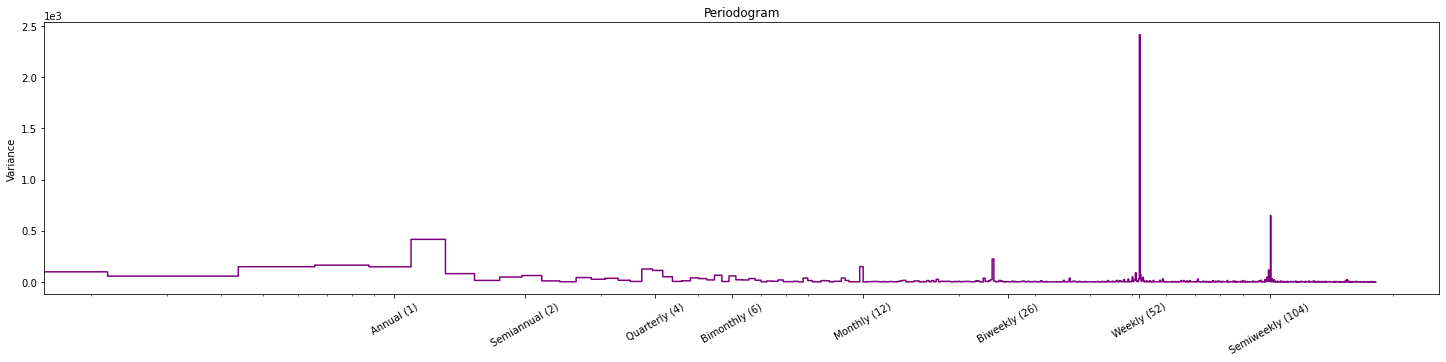

In [26]:
Total_sales = (store_sales_train.groupby('date').mean().squeeze())
plot_periodogram(Total_sales.sales)

In [39]:
def seasonal_plot(df, season='year', index='month', column=None):
    """Makes a seasonal plot of one column of the input dataframe. Considers the first columns by default.
    
    Arguments:
    
    - df (Pandas DataFrame): DataFrame indexed by Datetime (see `parse_dates` parameter when reading a CSV);
    - season (string): the season that you want to considering when doing the plot, e.g., year, month, etc.;
    - index (string): corresponds to the X axis of the plot. You should choose based on the index period that you're using;
    - column (string, optional): the DataFrame column to consider. Picks the first one by default.
    """
    if column == None:
        column = df.columns[0]
        
    piv_index = getattr(df.index, index)
    piv_season = getattr(df.index, season)
    
    piv = pd.pivot_table(df, index=piv_index, columns=piv_season, values=[column])
    piv.plot(figsize=(12,8))

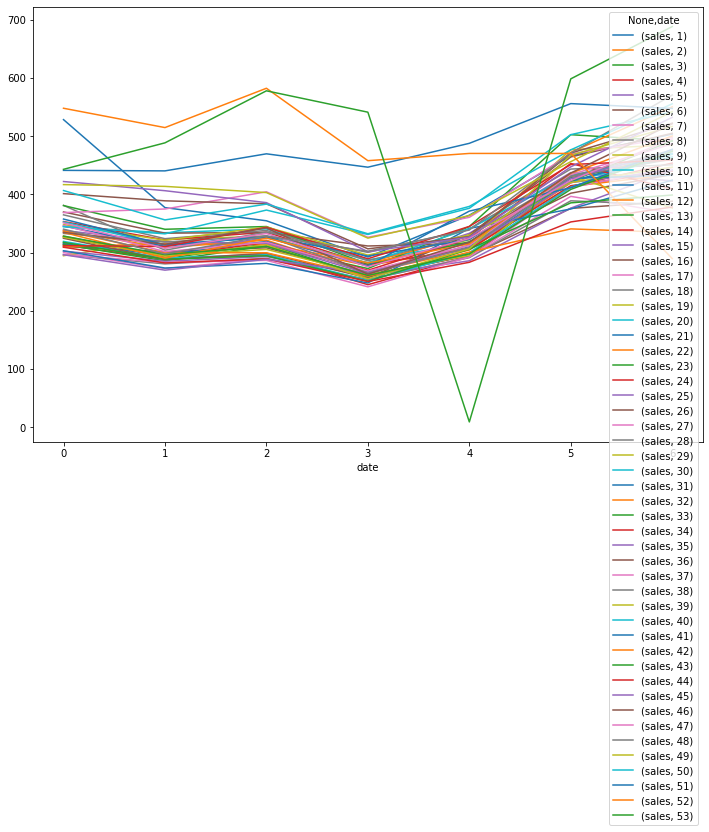

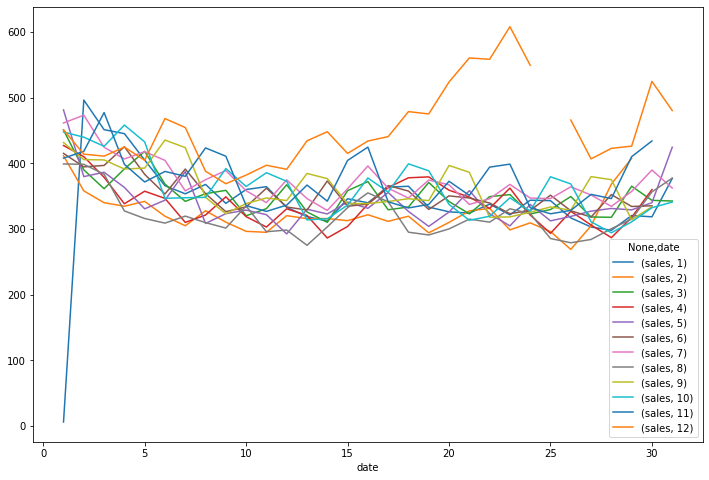

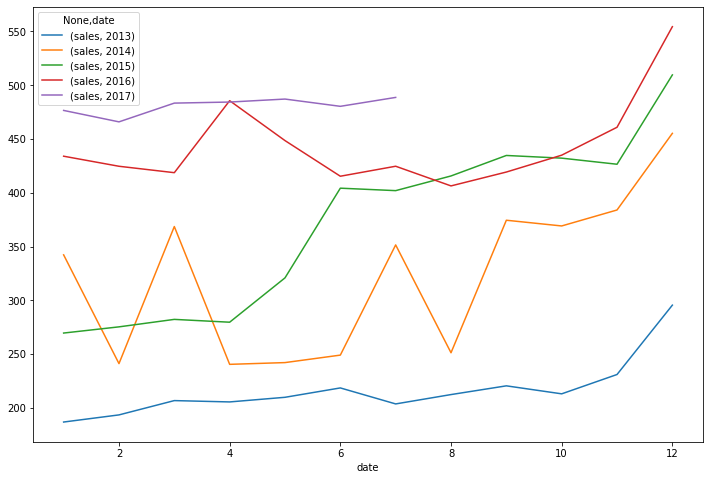

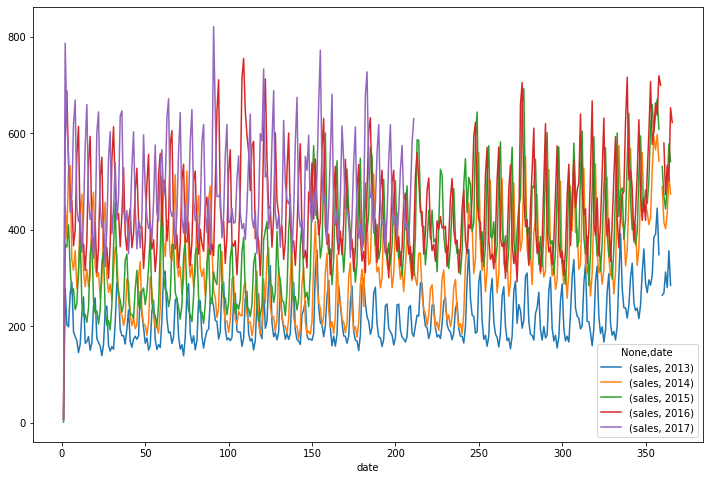

In [ ]:
seasonal_plot(Total_sales, season ='week', index='dayofweek', column ='sales')
seasonal_plot(Total_sales, season ='month', index='day', column ='sales')
seasonal_plot(Total_sales, season ='year', index='month', column ='sales')
seasonal_plot(Total_sales,season ='year', index='dayofyear', column ='sales')

Reduciendo el estudio a los dos últimos años

<AxesSubplot:title={'center':'Periodogram'}, ylabel='Variance'>

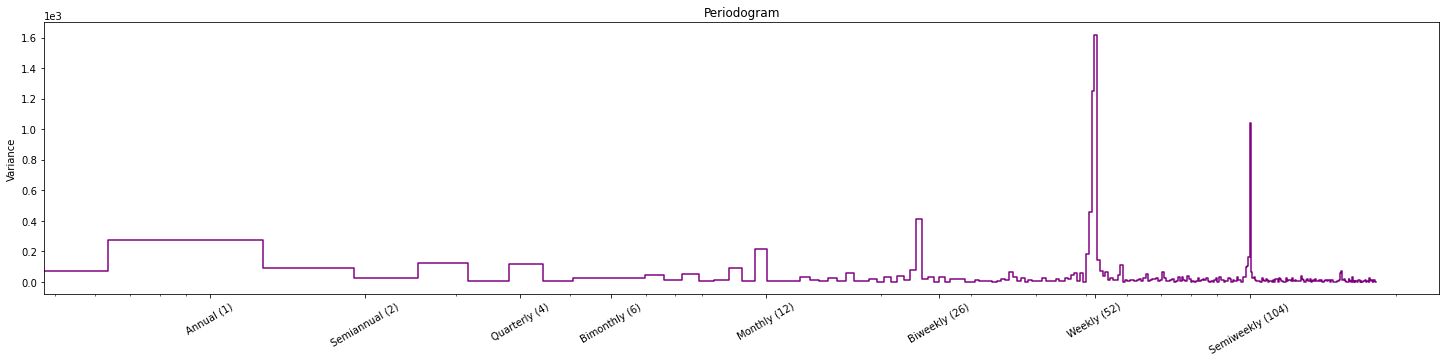

In [37]:
Total_sales.reset_index(inplace=True)
Total_sales_16_17 = Total_sales.loc[Total_sales['date']>='2016-01-01']
plot_periodogram(Total_sales_16_17.sales)

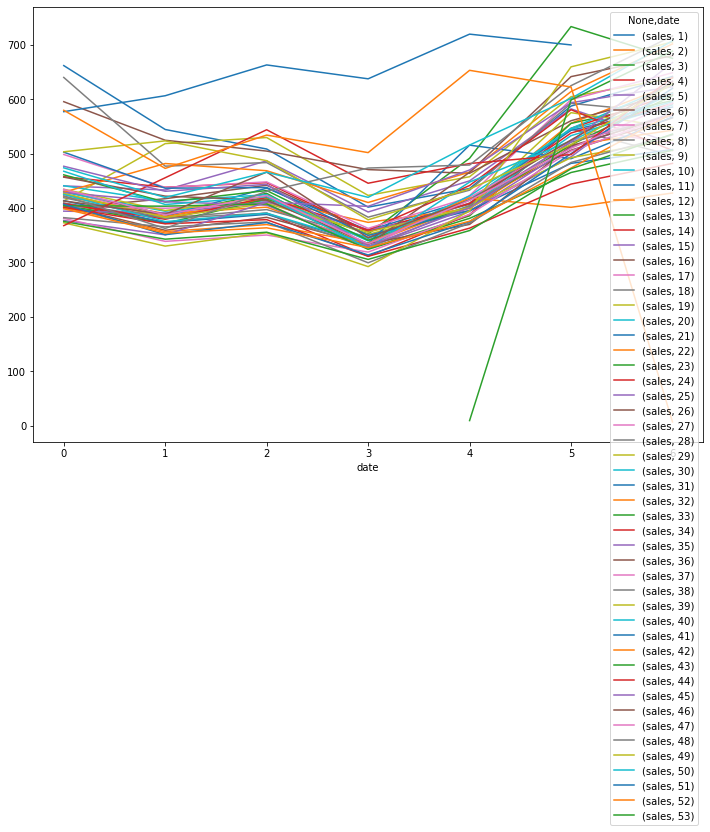

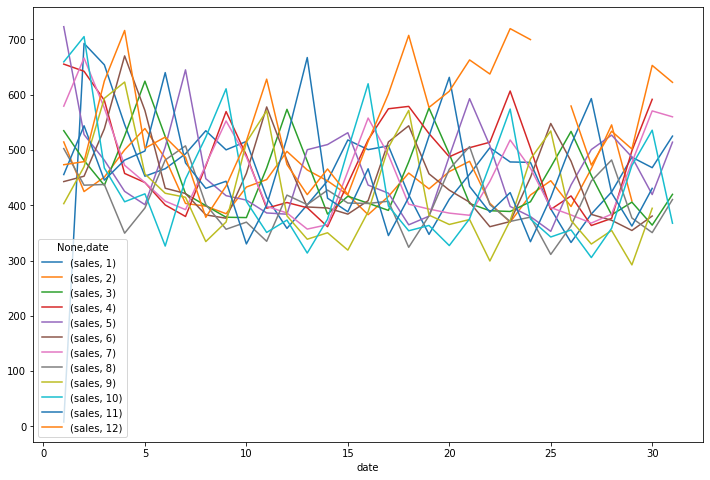

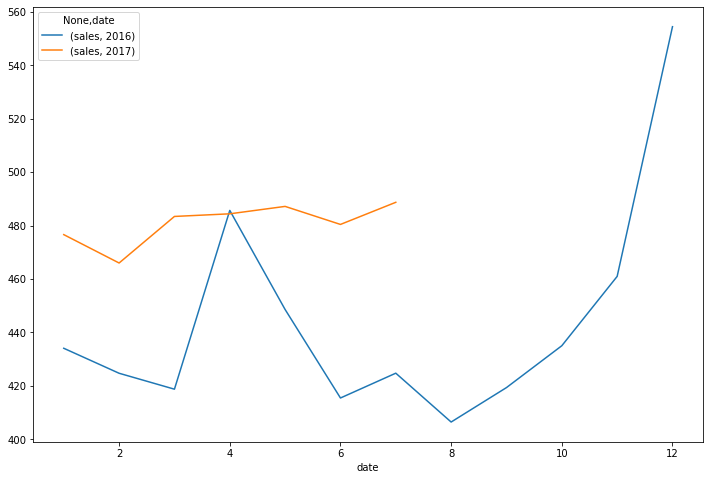

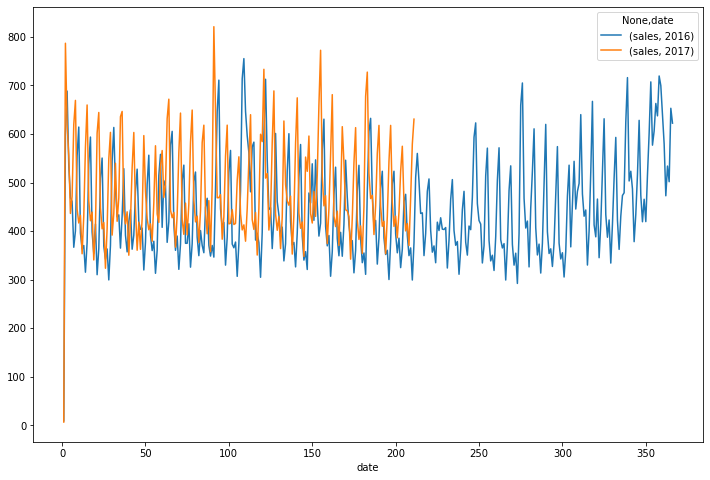

In [41]:
Total_sales_16_17.set_index(['date'], inplace = True)
seasonal_plot(Total_sales_16_17, season ='week', index='dayofweek', column ='sales')
seasonal_plot(Total_sales_16_17, season ='month', index='day', column ='sales')
seasonal_plot(Total_sales_16_17, season ='year', index='month', column ='sales')
seasonal_plot(Total_sales_16_17,season ='year', index='dayofyear', column ='sales')

Vuelve a confirmarse que se aprecia un patrón dentro de la semana, no así en los días de un mes o en los meses del año, donde si bien todos los años presentan un repunte en los meses finales del año, no hay patrón claro. Además, el peiodograma vuelve a incidir en la importancia de la temporalidad semanal, pero también hay un pico para la bisemanal, que podría deberse a los periodos de cobro, cuya relación cabrá estudiar.

**Se va a crear un trend feature usando deterministic process**

Con él, se va a ajustar un primer modelo de prueba para las ventas totales agrupadas por fecha

In [28]:
y = Total_sales.set_index(['date'])['sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()


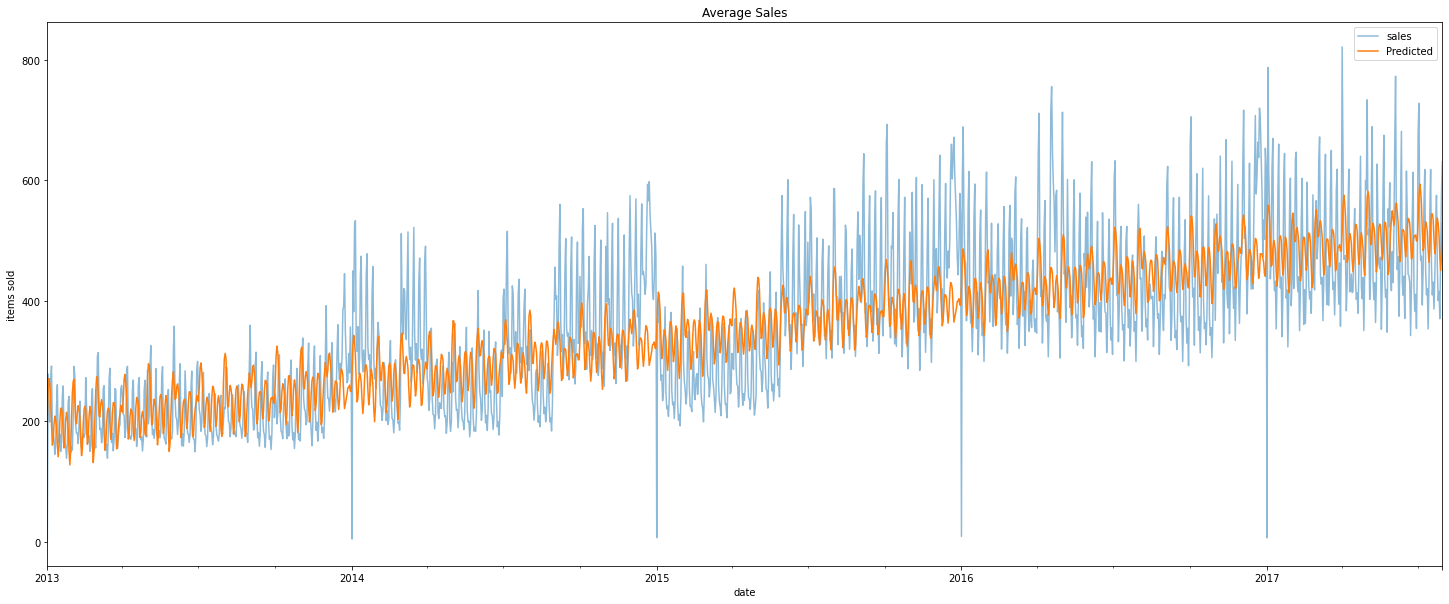

In [29]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index, name='Fitted')

ax = y.plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Predicted")
ax.legend();

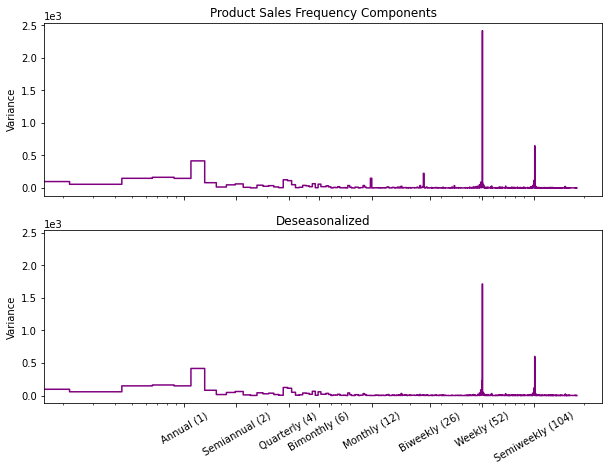

In [ ]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

Revisando a posteriori, no parece que el feature seleccionado haya trabajado muy bien, pues si bien parece haberse captado la temporalidad bisemanal o la mensual, no se puede decir lo mismo de la semanal

In [31]:
Total_sales_val = (store_sales_val.groupby('date').mean().squeeze())
y_val = Total_sales_val['sales']

In [32]:
X_fore = dp.out_of_sample(steps=16)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

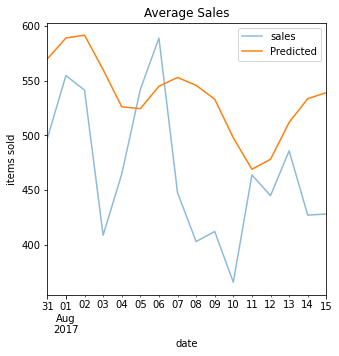

In [33]:
ax = y_val.plot(figsize = (5,5), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fore.plot(ax=ax, label="Predicted")
ax.legend();

Se procede a ver los resultados obtenidos para el primer modelo que se ha elaborado para las ventas totales agrupadas por fecha

In [34]:
import math

#A function to calculate Root Mean Squared Logarithmic Error (RMSLE)
def rmsle(y, y_pred):
	assert len(y) == len(y_pred)
	terms_to_sum = [(math.log(y_pred[i] + 1) - math.log(y[i] + 1)) ** 2.0 for i,pred in enumerate(y_pred)]
	return (sum(terms_to_sum) * (1.0/len(y))) ** 0.5

In [35]:
metrica_train = rmsle(y, y_pred)
metrica_val = rmsle(y_val, y_fore)

print("El valor del RMSLE en entrenamiento es: ", metrica_train)
print("El valor del RMSLE en validación es: ", metrica_val)

El valor del RMSLE en entrenamiento es:  0.3173993934527233
El valor del RMSLE en validación es:  0.18699793912397666


Ahora se va a hacer teniendo en cuenta sólo los datos de **2016 y 2017**, a ver si así mejora la cosa

In [42]:
y = Total_sales_16_17['sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()

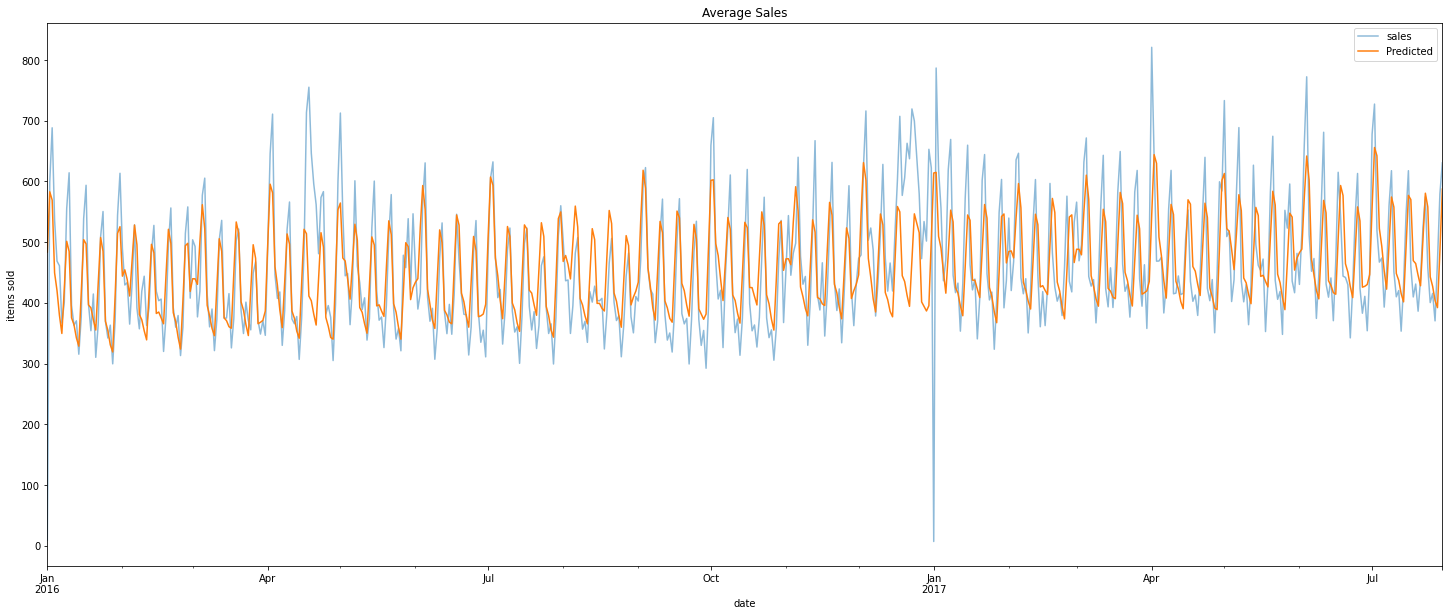

In [43]:
model = LinearRegression().fit(X, y)
y_pred = pd.Series(model.predict(X), index=X.index, name='Fitted')

ax = y.plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.plot(ax=ax, label="Predicted")
ax.legend();

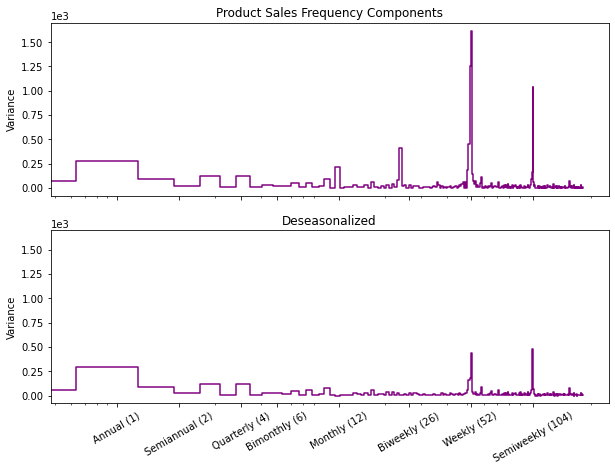

In [ ]:
y_deseason = y - y_pred

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))
ax1 = plot_periodogram(y, ax=ax1)
ax1.set_title("Product Sales Frequency Components")
ax2 = plot_periodogram(y_deseason, ax=ax2);
ax2.set_title("Deseasonalized");

Seleccionando únicamente los datos del 16-17 sí que parece haberse captado mucho mejor la temporalidad

In [44]:
X_fore = dp.out_of_sample(steps=16)
y_fore = pd.Series(model.predict(X_fore), index=X_fore.index)

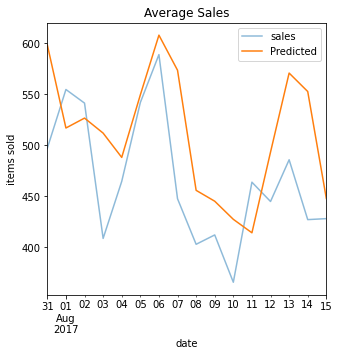

In [45]:
ax = y_val.plot(figsize = (5,5), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fore.plot(ax=ax, label="Predicted")
ax.legend();

In [46]:
metrica_train = rmsle(y, y_pred)
metrica_val = rmsle(y_val, y_fore)

print("El valor del RMSLE en entrenamiento es: ", metrica_train)
print("El valor del RMSLE en validación es: ", metrica_val)

El valor del RMSLE en entrenamiento es:  0.28015735223746885
El valor del RMSLE en validación es:  0.14116108367377533


Seleccionando únicamente los datos de estos dos años, los resultados parecen mejorar

**Se va a implementar este mismo modelo, pero haciendo una regresión para cada tienda y cada producto, primero considerando los datos de todos los años, después sólo los de 2016 y 2017**

In [47]:
y = store_sales_train.unstack(['store_nbr', 'family'])
y = y['sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()

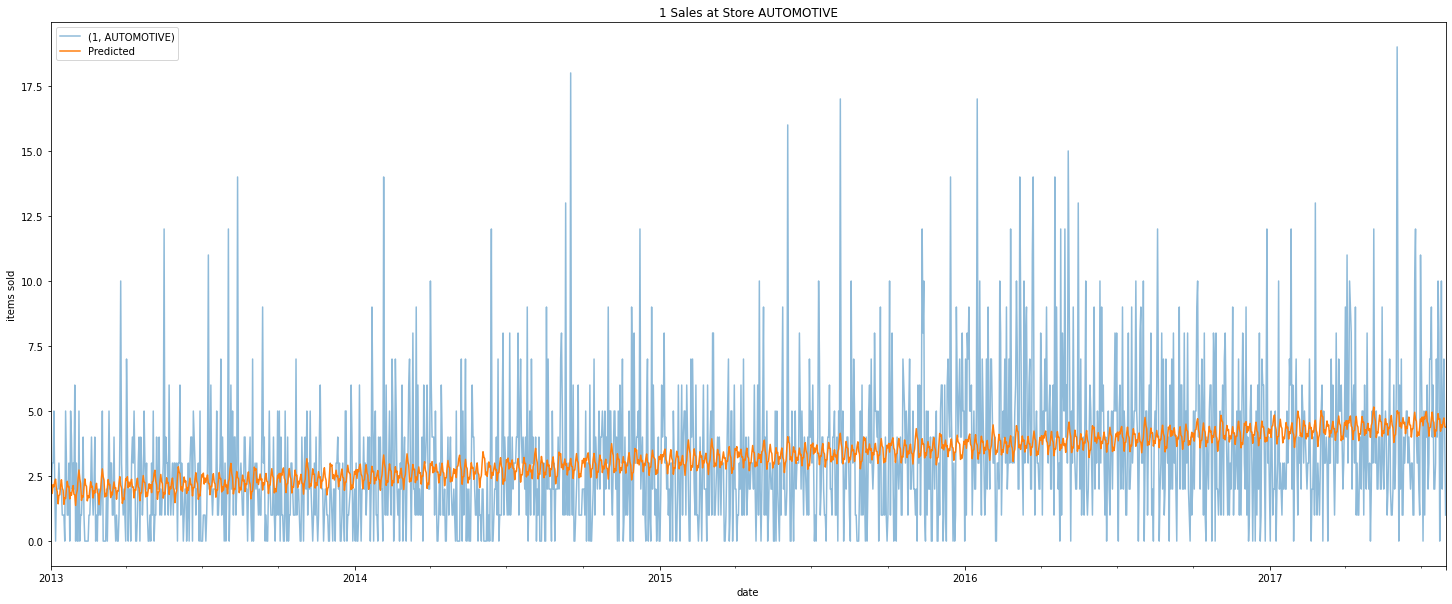

In [48]:
model = LinearRegression(fit_intercept=False).fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index, columns=y.columns)

FAMILY = 1
STORE_NBR = 'AUTOMOTIVE'
ax = y.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

In [49]:
y_val = store_sales_val.unstack(['store_nbr', 'family'])
y_val = y_val['sales']

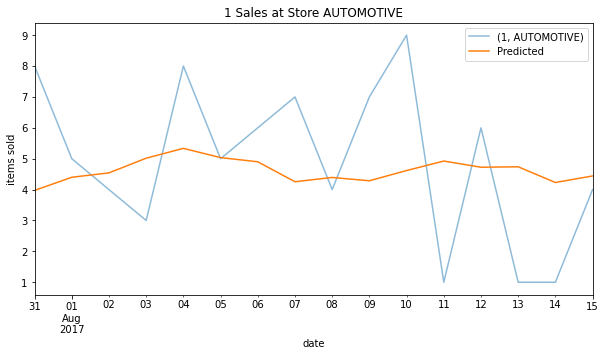

In [50]:
X_fore = dp.out_of_sample(steps=16)
y_fore = pd.DataFrame(model.predict(X_fore), index= y_val.index, columns=y_val.columns)

FAMILY = 1
STORE_NBR = 'AUTOMOTIVE'
ax = y_val.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (10,5), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fore.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

In [51]:
y_pred = pd.DataFrame(y_pred.stack(['store_nbr', 'family']))
y_pred = y_pred.reset_index()
y_pred = y_pred.set_index(['store_nbr', 'family', 'date']).sort_index()
y_pred.columns = ['sales']
y_fore = pd.DataFrame(y_fore.stack(['store_nbr', 'family']))
y_fore = y_fore.reset_index()
y_fore = y_fore.set_index(['store_nbr', 'family', 'date']).sort_index()
y_fore.columns = ['sales']

In [52]:
y_pred['sales'][y_pred['sales']<0] = 0
y_fore['sales'][y_fore['sales']<0] = 0

In [53]:
metrica_train = rmsle(np.array(store_sales_train['sales']), np.array(y_pred['sales']))
metrica_val = rmsle(np.array(store_sales_val['sales']), np.array(y_fore['sales']))

print("El valor del RMSLE en entrenamiento es: ", metrica_train)
print("El valor del RMSLE en validación es: ", metrica_val)

El valor del RMSLE en entrenamiento es:  1.184098723164164
El valor del RMSLE en validación es:  0.600104062292227


El valor ne entrenamiento es mucho peor que en validación debido a la tendencia creciente que se tiene, que la regresión lineal empleada ajusta de forma lineal, coincidiento en mayor medida con los 16 días empleados para validación que con todos los datos de entrenamiento en los que se tienen subidas y bajadas

Ahora se va a hacer lo mismo, pero tomando sólo los datos de 2016 y 2017

In [54]:
store_sales_train_16_17 = store_sales_train.reset_index()
store_sales_train_16_17 = store_sales_train_16_17.loc[store_sales_train_16_17['date']>='2016-01-01']
store_sales_train_16_17 = store_sales_train_16_17.set_index(['store_nbr', 'family', 'date']).sort_index()

In [55]:
y = store_sales_train_16_17.unstack(['store_nbr', 'family'])
y = y['sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()

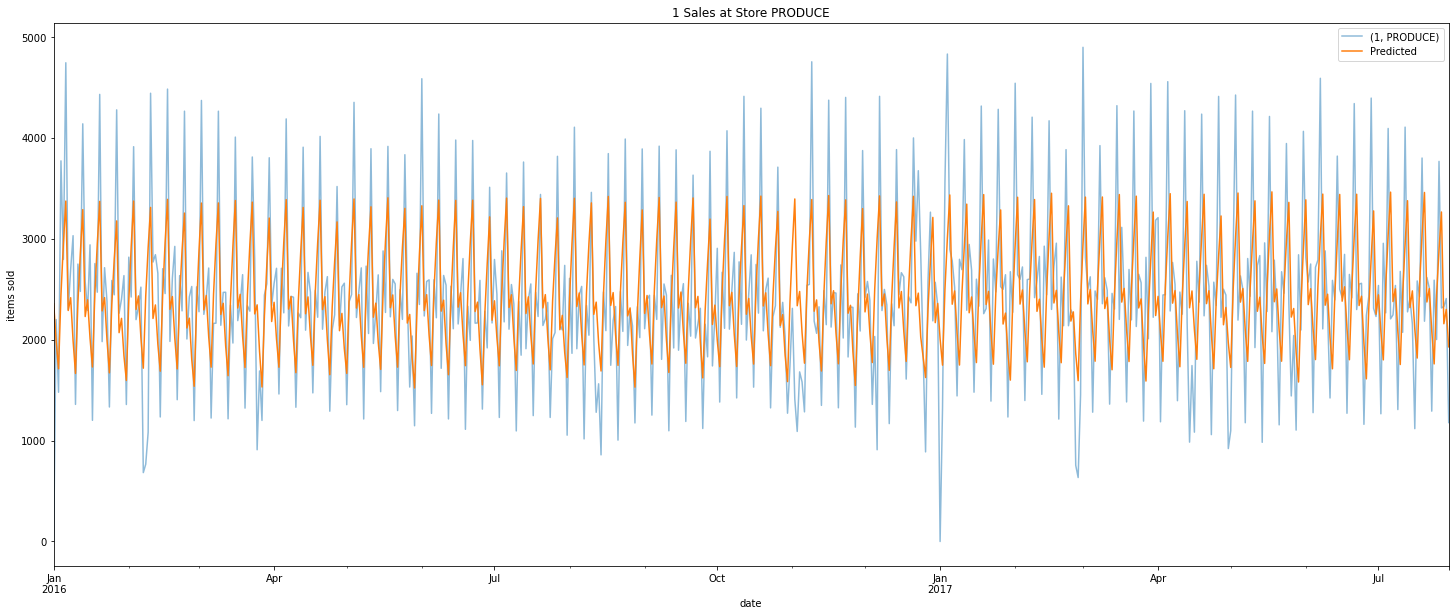

In [58]:
model = LinearRegression(fit_intercept=False).fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index, columns=y.columns)

FAMILY = 1
STORE_NBR = 'PRODUCE'
ax = y.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

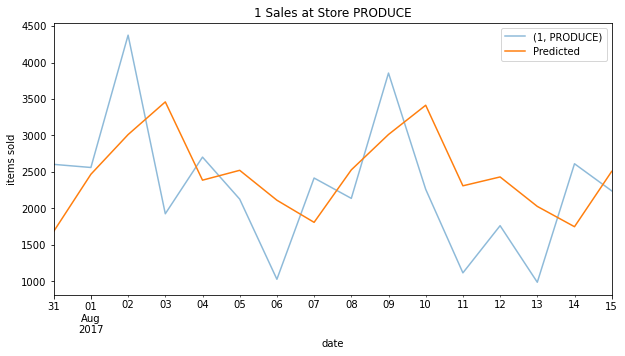

In [59]:
X_fore = dp.out_of_sample(steps=16)
y_fore = pd.DataFrame(model.predict(X_fore), index= y_val.index, columns=y_val.columns)

FAMILY = 1
STORE_NBR = 'PRODUCE'
ax = y_val.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (10,5), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fore.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

In [60]:
y_pred = pd.DataFrame(y_pred.stack(['store_nbr', 'family']))
y_pred = y_pred.reset_index()
y_pred = y_pred.set_index(['store_nbr', 'family', 'date']).sort_index()
y_pred.columns = ['sales']
y_fore = pd.DataFrame(y_fore.stack(['store_nbr', 'family']))
y_fore = y_fore.reset_index()
y_fore = y_fore.set_index(['store_nbr', 'family', 'date']).sort_index()
y_fore.columns = ['sales']

In [61]:
y_pred

sales
store_nbr family     date                
1         AUTOMOTIVE 2016-01-01  5.183366
                     2016-01-02  4.774110
                     2016-01-03  3.591872
                     2016-01-04  5.370420
                     2016-01-05  5.654148
...                                   ...
54        SEAFOOD    2017-07-26  2.934694
                     2017-07-27  2.360013
                     2017-07-28  1.702974
                     2017-07-29  2.109134
                     2017-07-30  2.619987

[1026432 rows x 1 columns]

In [62]:
y_pred['sales'][y_pred['sales']<0] = 0
y_fore['sales'][y_fore['sales']<0] = 0

In [63]:
metrica_train = rmsle(np.array(store_sales_train_16_17['sales']), np.array(y_pred['sales']))
metrica_val = rmsle(np.array(store_sales_val['sales']), np.array(y_fore['sales']))

print("El valor del RMSLE en entrenamiento es: ", metrica_train)
print("El valor del RMSLE en validación es: ", metrica_val)

El valor del RMSLE en entrenamiento es:  0.7367012721025465
El valor del RMSLE en validación es:  0.5727023033472943


Por último, considerando únicamente datos de 2017

In [64]:
store_sales_train_17 = store_sales_train.reset_index()
store_sales_train_17 = store_sales_train_17.loc[store_sales_train_17['date']>='2017-01-01']
store_sales_train_17 = store_sales_train_17.set_index(['store_nbr', 'family', 'date']).sort_index()

In [65]:
y = store_sales_train_17.unstack(['store_nbr', 'family'])
y = y['sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()

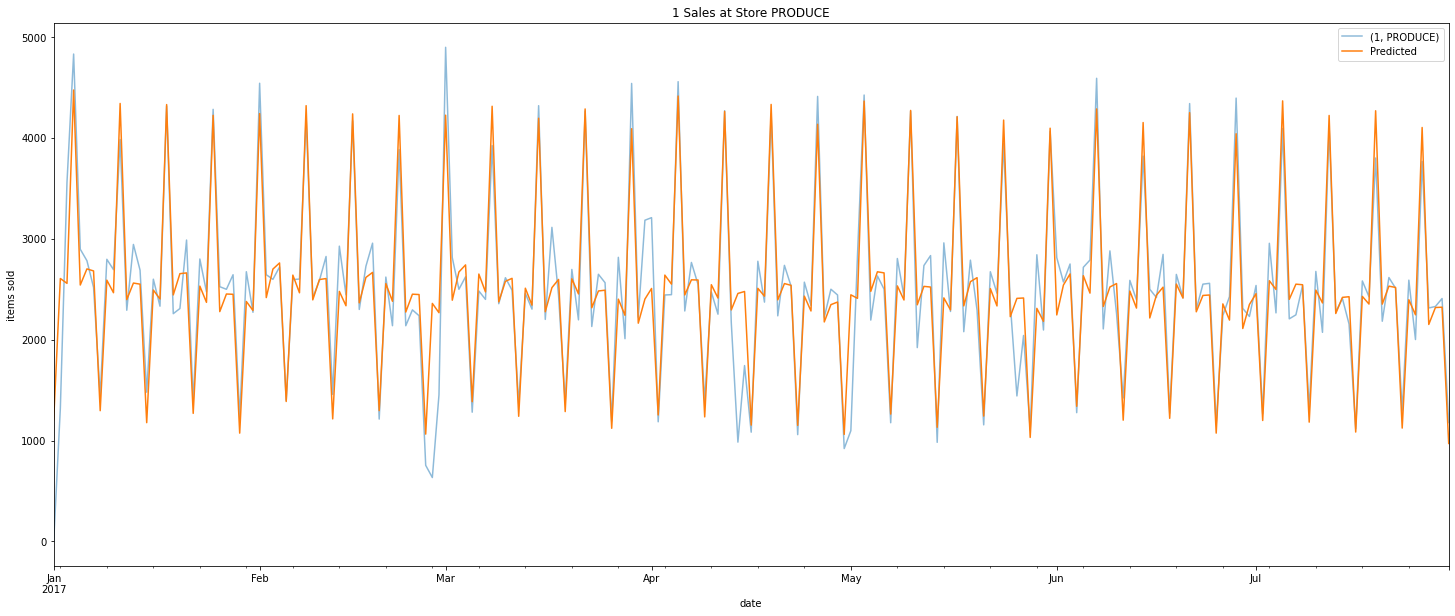

In [66]:
model = LinearRegression(fit_intercept=False).fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index, columns=y.columns)

FAMILY = 1
STORE_NBR = 'PRODUCE'
ax = y.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

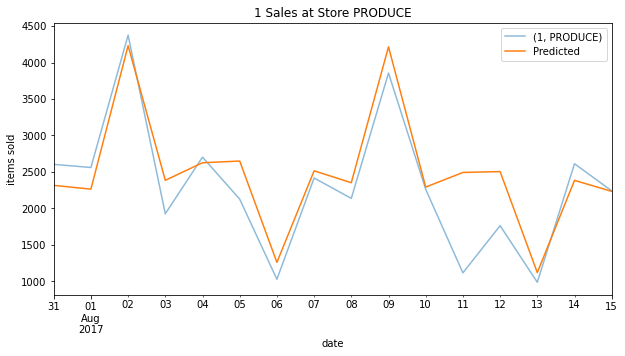

In [67]:
X_fore = dp.out_of_sample(steps=16)
y_fore = pd.DataFrame(model.predict(X_fore), index= y_val.index, columns=y_val.columns)

FAMILY = 1
STORE_NBR = 'PRODUCE'
ax = y_val.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (10,5), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_fore.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

In [68]:
y_pred = pd.DataFrame(y_pred.stack(['store_nbr', 'family']))
y_pred = y_pred.reset_index()
y_pred = y_pred.set_index(['store_nbr', 'family', 'date']).sort_index()
y_pred.columns = ['sales']
y_fore = pd.DataFrame(y_fore.stack(['store_nbr', 'family']))
y_fore = y_fore.reset_index()
y_fore = y_fore.set_index(['store_nbr', 'family', 'date']).sort_index()
y_fore.columns = ['sales']

In [71]:
y_pred['sales'][y_pred['sales']<0] = 0
y_fore['sales'][y_fore['sales']<0] = 0

In [72]:
metrica_train = rmsle(np.array(store_sales_train_17['sales']), np.array(y_pred['sales']))
metrica_val = rmsle(np.array(store_sales_val['sales']), np.array(y_fore['sales']))

print("El valor del RMSLE en entrenamiento es: ", metrica_train)
print("El valor del RMSLE en validación es: ", metrica_val)

El valor del RMSLE en entrenamiento es:  0.6240287920714146
El valor del RMSLE en validación es:  0.5759639928302321


Si bien el RMSLE es ligerísimamente peor al que se tenía tomando datos tanto de 2016 como de 2017, el reultado en train es mucbo mejor y ambos son mucho más similares, lo cual resulta positivo y por ello se van a tomar únicamente datos de 2017 para entrenar

# Código para enviar a Kaggle

In [74]:
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

In [77]:
store_sales_train = pd.read_csv('train.csv')
store_sales_test = pd.read_csv('test.csv')

***Data Preprocessing***

In [78]:
store_sales_train['date'] = pd.to_datetime(store_sales_train['date'])
store_sales_train['date'] = store_sales_train.date.dt.to_period('D')
store_sales_test['date'] = pd.to_datetime(store_sales_test['date'])
store_sales_test['date'] = store_sales_test.date.dt.to_period('D')

Considerando únicamente datos de 2017

In [81]:
store_sales_train_17 = store_sales_train.loc[store_sales_train['date']>='2017-01-01']
store_sales_train_17 = store_sales_train_17.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales_test = store_sales_test.set_index(['store_nbr', 'family', 'date']).sort_index()

In [82]:
y = store_sales_train_17.unstack(['store_nbr', 'family'])
y = y['sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()

**Además de la regresión lineal clásica, se va a probar con Lasso y Ridge, a ver qué modelo ofrece mejores resultados**

In [83]:
model = LinearRegression(fit_intercept=False).fit(X, y)
y_pred = pd.DataFrame(model.predict(X), index=y.index, columns=y.columns)

model2 = Lasso(fit_intercept=False).fit(X, y)
y_pred2 = pd.DataFrame(model2.predict(X), index=y.index, columns=y.columns)

model3 = Ridge(fit_intercept=False).fit(X, y)
y_pred3 = pd.DataFrame(model3.predict(X), index=y.index, columns=y.columns)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:530: ConvergenceWarning:

Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.0, tolerance: 0.0



In [84]:
X_fore = dp.out_of_sample(steps=16)
X_fore.index.name = 'date'

**Modelo 1 LR**

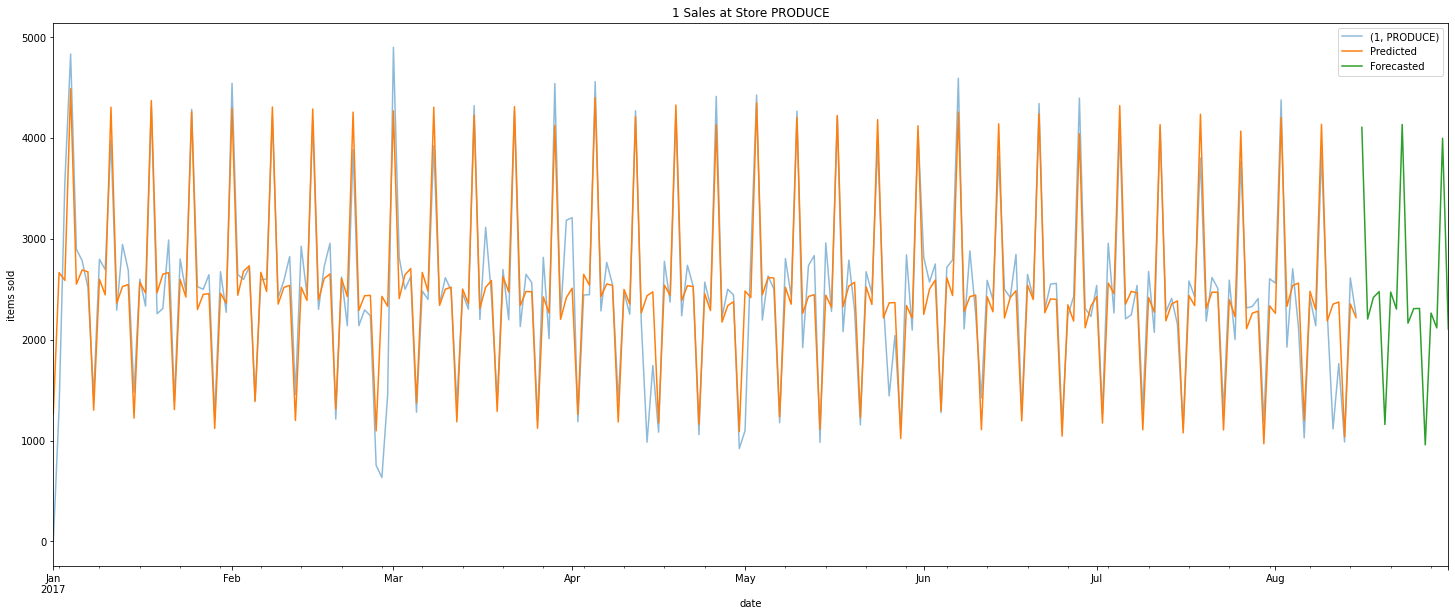

In [ ]:
y_fore = pd.DataFrame(model.predict(X_fore), index=X_fore.index, columns=y.columns)

FAMILY = 1
STORE_NBR = 'PRODUCE'
ax = y.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax = y_fore.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Forecasted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

In [ ]:
y_pred = pd.DataFrame(y_pred.stack(['store_nbr', 'family']))
y_pred = y_pred.reset_index()
y_pred = y_pred.set_index(['store_nbr', 'family', 'date']).sort_index()
y_pred.columns = ['sales']
y_pred['sales'][y_pred['sales']<0] = 0
y_fore[y_fore<0] = 0

In [ ]:
metrica_train = rmsle(np.array(store_sales_train_17['sales']), np.array(y_pred['sales']))

print("El valor del RMSLE en entrenamiento es: ", metrica_train)

El valor del RMSLE en entrenamiento es:  0.6270044737341588


In [ ]:
y_fore_df = pd.DataFrame(y_fore.stack(['store_nbr', 'family']))
y_submit = y_fore_df.join(store_sales_test.id)
y_submit.columns = ['sales','id']
y_submit=y_submit.set_index('id')
y_submit.sort_index(inplace=True)
y_submit.to_csv('submission.csv')

**El RMSLE obtenido en esta primera entrega en Kaggle ha sido de 0.51084**

**Modelo 2 Lasso**

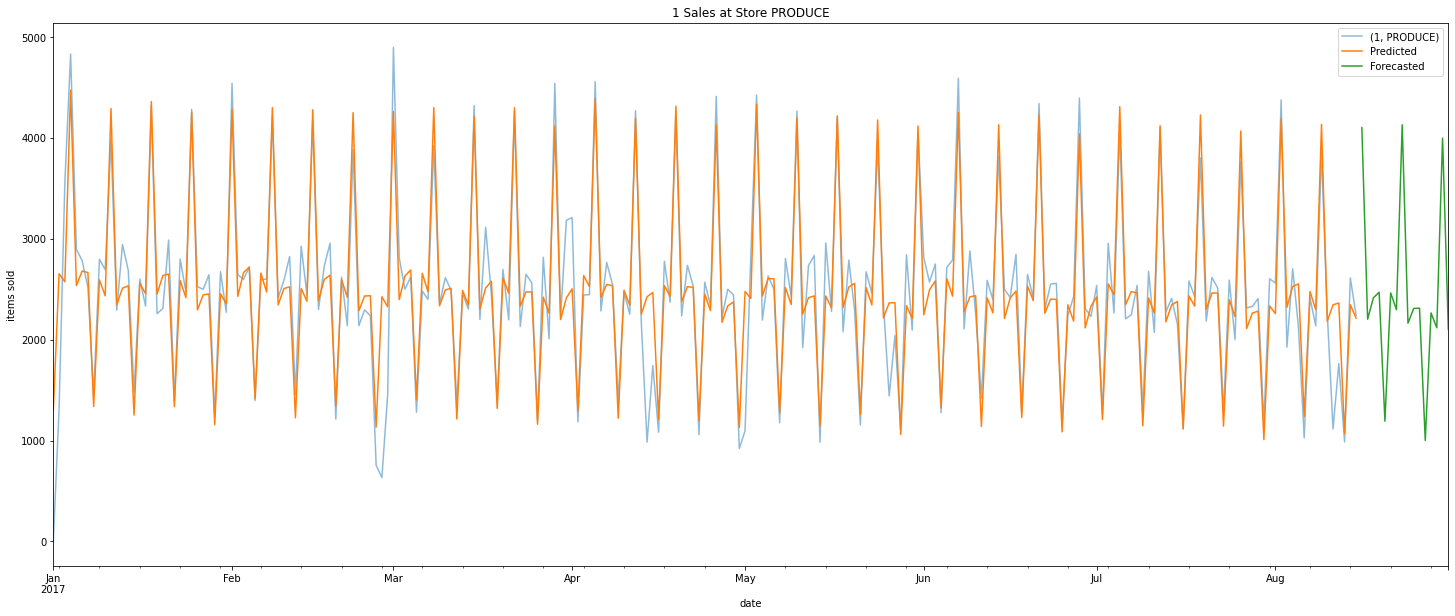

In [ ]:
y_fore2 = pd.DataFrame(model2.predict(X_fore), index=X_fore.index, columns=y.columns)

FAMILY = 1
STORE_NBR = 'PRODUCE'
ax = y.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred2.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax = y_fore2.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Forecasted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

In [ ]:
y_pred2 = pd.DataFrame(y_pred2.stack(['store_nbr', 'family']))
y_pred2 = y_pred2.reset_index()
y_pred2 = y_pred2.set_index(['store_nbr', 'family', 'date']).sort_index()
y_pred2.columns = ['sales']
y_pred2['sales'][y_pred2['sales']<0] = 0
y_fore2[y_fore2<0] = 0

In [ ]:
metrica_train2 = rmsle(np.array(store_sales_train_17['sales']), np.array(y_pred2['sales']))

print("El valor del RMSLE con Lasso en entrenamiento es: ", metrica_train2)

El valor del RMSLE con Lasso en entrenamiento es:  0.6569259940628401


Vistos los resultados no se llegó a enviar sumisión de este modelo a kaggle

**Modelo 3 Ridge**

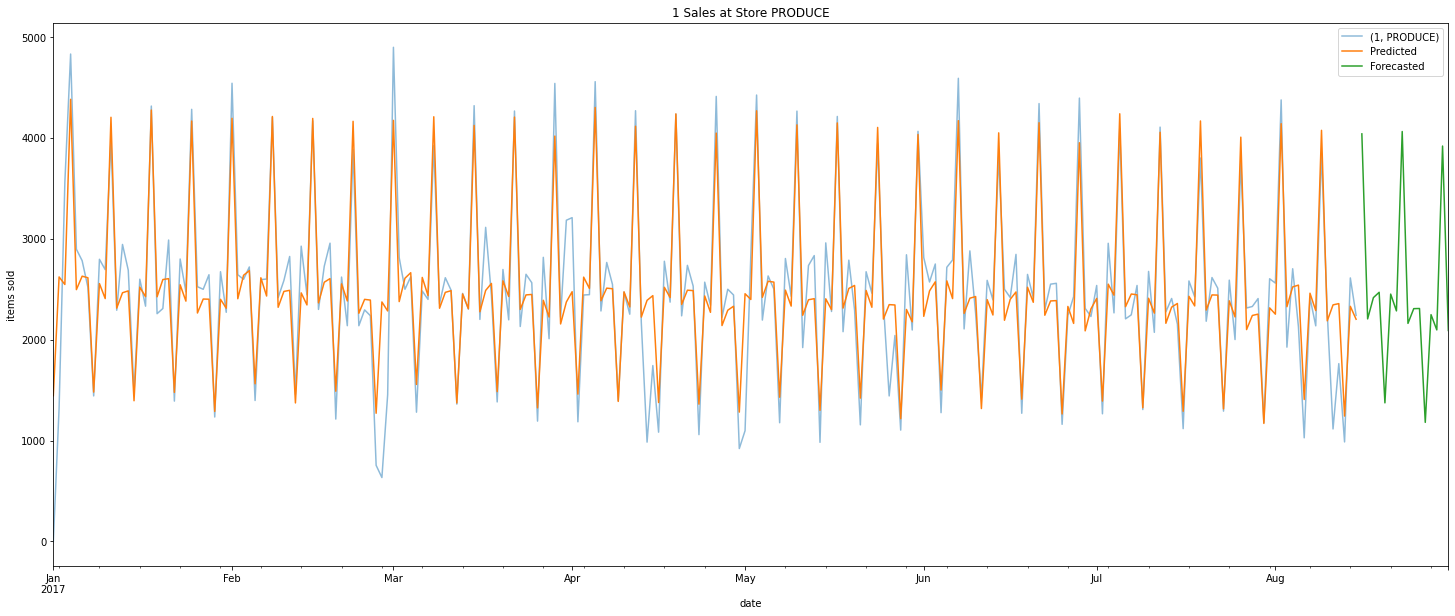

In [ ]:
y_fore3 = pd.DataFrame(model3.predict(X_fore), index=X_fore.index, columns=y.columns)

FAMILY = 1
STORE_NBR = 'PRODUCE'
ax = y.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred3.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax = y_fore3.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Forecasted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

In [ ]:
y_pred3 = pd.DataFrame(y_pred3.stack(['store_nbr', 'family']))
y_pred3 = y_pred3.reset_index()
y_pred3 = y_pred3.set_index(['store_nbr', 'family', 'date']).sort_index()
y_pred3.columns = ['sales']
y_pred3['sales'][y_pred3['sales']<0] = 0
y_fore3[y_fore3<0] = 0

In [ ]:
metrica_train3 = rmsle(np.array(store_sales_train_17['sales']), np.array(y_pred3['sales']))

print("El valor del RMSLE con Ridge en entrenamiento es: ", metrica_train3)

El valor del RMSLE con Ridge en entrenamiento es:  0.6256351721290737


In [ ]:
y_fore3_df = pd.DataFrame(y_fore3.stack(['store_nbr', 'family']))
y_submit3 = y_fore3_df.join(store_sales_test.id)
y_submit3.columns = ['sales','id']
y_submit3=y_submit3.set_index('id')
y_submit3.sort_index(inplace=True)
y_submit3.to_csv('submission2.csv')

**El RMSLE obtenido con este modelo fue de 0.51016, ligeramente mejor que el del modelo con LR**

# Teniendo en cuenta las vacaciones

In [ ]:
# Setup notebook
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.graph_objects as go
from sklearn.linear_model import LinearRegression, Lasso, Ridge

In [ ]:
store_sales_train = pd.read_csv('train.csv')
store_sales_test = pd.read_csv('test.csv')
holidays_events = pd.read_csv('holidays_events.csv', dtype={'type': 'category','locale': 'category',
                            'locale_name': 'category','description': 'category','transferred': 'bool',}, parse_dates=['date'], infer_datetime_format=True)

***Data Preprocessing***

In [ ]:
store_sales_train['date'] = pd.to_datetime(store_sales_train['date'])
store_sales_train['date'] = store_sales_train.date.dt.to_period('D')
store_sales_test['date'] = pd.to_datetime(store_sales_test['date'])
store_sales_test['date'] = store_sales_test.date.dt.to_period('D')

In [ ]:
store_sales_train_17 = store_sales_train.loc[store_sales_train['date']>='2017-01-01']
store_sales_train_17 = store_sales_train_17.set_index(['store_nbr', 'family', 'date']).sort_index()
store_sales_test = store_sales_test.set_index(['store_nbr', 'family', 'date']).sort_index()

**En este caso, en el modelo se va a considerar también los días de vacaciones**

In [ ]:
y = store_sales_train_17.unstack(['store_nbr', 'family'])
y = y['sales']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal=True,
    additional_terms=[fourier],
    drop=True
)
X = dp.in_sample()

In [ ]:
holidays_events = holidays_events.set_index('date').to_period('D')

holidays_17 = (
    holidays_events
    .query("locale in ['National']")
    .loc['2017':'2017-08-31', ['type','transferred']]
)

holidays_17.drop(holidays_17[holidays_17['transferred']==True].index,axis=0,inplace=True)
holidays_17.rename(columns = {'type':'event_type'}, inplace=True)

holidays_17.loc[holidays_17['event_type'].isin(['Holiday','Transfer','Additional', 'Bridge']),'Free_day']=1
holidays_17.loc[holidays_17['event_type'].isin(['Event']),'Event']=1
holidays_17['Free_day'].fillna(0,inplace=True)
holidays_17['Event'].fillna(0,inplace=True)

display(holidays_17)

event_type  transferred  Free_day  Event
date                                                
2017-01-02    Transfer        False       1.0    0.0
2017-02-27     Holiday        False       1.0    0.0
2017-02-28     Holiday        False       1.0    0.0
2017-04-14     Holiday        False       1.0    0.0
2017-05-01     Holiday        False       1.0    0.0
2017-05-13  Additional        False       1.0    0.0
2017-05-14       Event        False       0.0    1.0
2017-05-26    Transfer        False       1.0    0.0
2017-08-11    Transfer        False       1.0    0.0

In [ ]:
X2 = X.join(holidays_17[['Free_day','Event']], on='date').fillna(0.0)
X2['NewYear'] = (X2.index.dayofyear == 1)

In [ ]:
model3 = Ridge(fit_intercept=False).fit(X2, y)
y_pred3 = pd.DataFrame(model3.predict(X2), index=y.index, columns=y.columns)

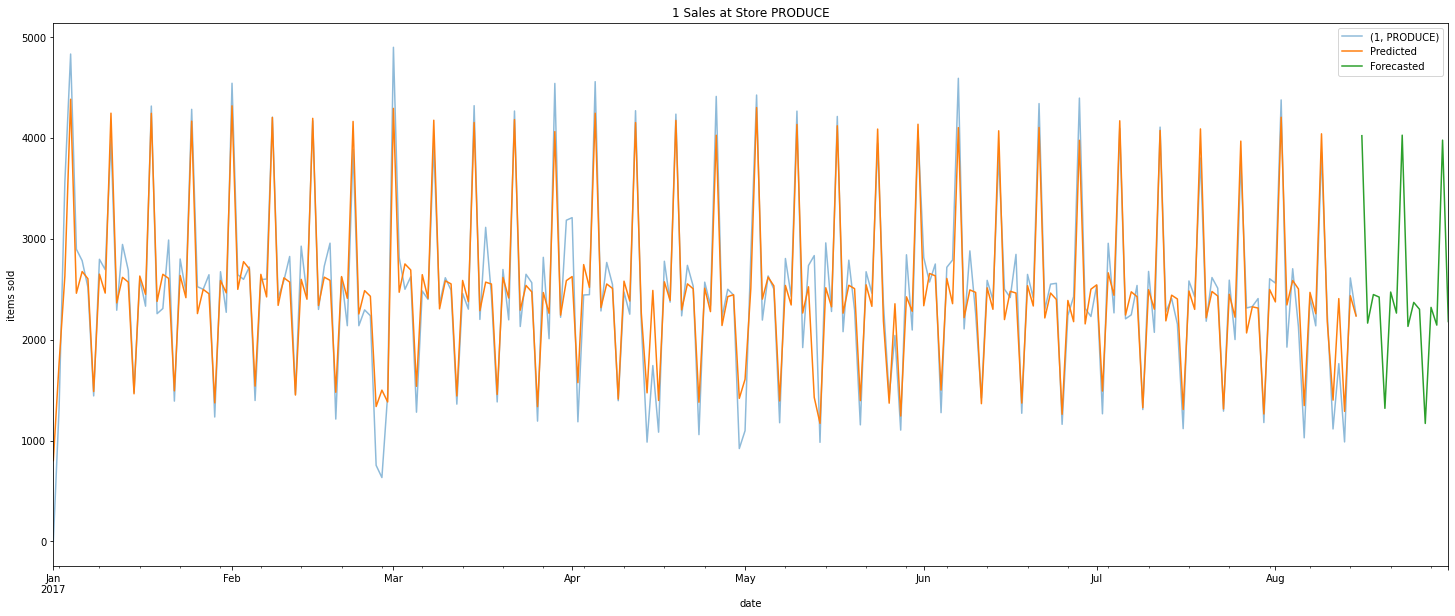

In [ ]:
X_fore = dp.out_of_sample(steps=16)
X_fore.index.names=['date']
X_fore = X_fore.join(holidays_17[['Free_day','Event']], on='date').fillna(0.0)
X_fore['NewYear'] = (X_fore.index.dayofyear == 1)
y_fore3 = pd.DataFrame(model3.predict(X_fore), index=X_fore.index, columns=y.columns)

FAMILY = 1
STORE_NBR = 'PRODUCE'
ax = y.loc(axis=1)[FAMILY,STORE_NBR].plot(figsize = (25,10), alpha=0.5, title="Average Sales", ylabel="items sold")
ax = y_pred3.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Predicted")
ax = y_fore3.loc(axis=1)[FAMILY,STORE_NBR].plot(ax=ax, label="Forecasted")
ax.set_title(f'{FAMILY} Sales at Store {STORE_NBR}');
ax.legend();

In [ ]:
y_pred3 = pd.DataFrame(y_pred3.stack(['store_nbr', 'family']))
y_pred3 = y_pred3.reset_index()
y_pred3 = y_pred3.set_index(['store_nbr', 'family', 'date']).sort_index()
y_pred3.columns = ['sales']
y_pred3['sales'][y_pred3['sales']<0] = 0
y_fore3[y_fore3<0] = 0
y_fore3_df = pd.DataFrame(y_fore3.stack(['store_nbr', 'family']))
y_submit3 = y_fore3_df.join(store_sales_test.id)
y_submit3.columns = ['sales','id']
y_submit3=y_submit3.set_index('id')
y_submit3.sort_index(inplace=True)

In [ ]:
metrica_train3 = rmsle(np.array(store_sales_train_17['sales']), np.array(y_pred3['sales']))

print("El valor del RMSLE con Ridge en entrenamiento es: ", metrica_train3)

El valor del RMSLE con Ridge en entrenamiento es:  0.6062754728655452


In [ ]:
y_submit3.to_csv('submission3.csv')

**El RMSLE en este caso es de 0.50788, por lo que hay una ligera mejora al tener en cuenta las vacaciones**
Destacar también que en un modelo se han implementado los datos del precio del petróleo como variable predictora y el RMSLe se ha reducido a 0.51076